# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from timeit import default_timer as timer

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

/home/rickya/anaconda3/lib/python3.7/site-packages/pycodestyle.py:113: FutureWarning: Possible nested set at position 1
  EXTRANEOUS_WHITESPACE_REGEX = re.compile(r'[[({] | []}),;:]')


In [2]:
#%%pycodestyle


class MyKmeans:
    def __init__(self, k=2, eps=1e-2, metric='euclidean',
                 max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.eps = eps

        if init == 'random':
            self.init = self._rand_init
        else:
            self.init = self._smart_init

    def _rand_init(self, X):
        self.centroids = X[np.random.choice(X.shape[0],
                                            size=self.k, replace=False)]

    def _smart_init(self, X):
        self.centroids[0] = X[np.random.choice(X.shape[0])]
        for i in range(1, self.k):
            d = self.dist(X, self.centroids[:i]).min(axis=1)
            w = d / d.sum()
            self.centroids[i] = X[np.random.choice(X.shape[0], p=w)]

    @staticmethod
    def dist(X, Y):
        xd = (X ** 2).sum(axis=1)
        yd = (Y ** 2).sum(axis=1)
        xyd = X.dot(Y.T)
        d = -2 * xyd + yd + xd.reshape(-1, 1)
        d[d < 0] = 0

        return d

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        X = X.astype(np.float)
        self.init(X)

        for _ in range(self.max_iter):
            delta = 0
            self.labels = self.dist(X, self.centroids).argmin(axis=1)
            for i in range(self.k):
                if np.any(self.labels == i):
                    new_centroid = np.mean(X[self.labels == i], axis=0)
                else:
                    new_centroid = X[np.random.choice(X.shape[0])]
                delta = max(delta,
                            np.abs(self.centroids[i] - new_centroid).sum())
                self.centroids[i] = new_centroid

            if delta < self.eps:
                break
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        return self.dist(X, self.centroids).argmin(axis=1)


class MiniBatchKMeans(MyKmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', n_batches=10):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максимальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        :n_batches - количество батчей
        """

        super(MiniBatchKMeans, self).__init__(
            k=k, metric=metric, max_iter=max_iter,
            random_state=random_state, init=init
        )
        self.n_batches = n_batches

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        X = X.astype(float)

        self.init(X)

        cnt = np.zeros(self.k)
        for _ in range(self.max_iter):
            batch = X[np.random.choice(X.shape[0],
                                       size=min(self.n_batches, X.shape[0]),
                                       replace=False)]
            self.labels = self.dist(batch, self.centroids).argmin(axis=1)
            delta = 0
            for i in range(batch.shape[0]):
                j = self.labels[i]
                cnt[j] += 1
                alpha = 1 / cnt[j]
                new_centroid = (1 - alpha) * self.centroids[j] + \
                    alpha * batch[i]
                delta = max(delta,
                            np.abs(self.centroids[j] - new_centroid).sum())
                self.centroids[j] = new_centroid
            if delta < self.eps:
                break

        self.labels = self.dist(X, self.centroids).argmin(axis=1)

        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

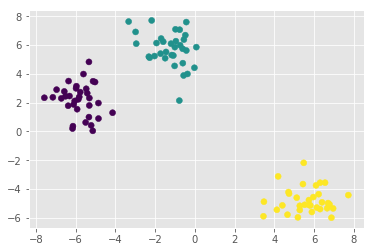

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [6]:
def test(model):
    if isinstance(model, KMeans):
        labels = model.fit(X).labels_
        for centroid in model.cluster_centers_:
            plt.scatter(*centroid, s=2000)
        plt.scatter(X[:, 0], X[:, 1], c=y)
    else:
        labels = model.fit(X).labels
        for centroid in model.centroids:
            plt.scatter(*centroid, s=2000)
        plt.scatter(X[:, 0], X[:, 1], c=y)

CPU times: user 15.1 ms, sys: 3.89 ms, total: 19 ms
Wall time: 17.6 ms


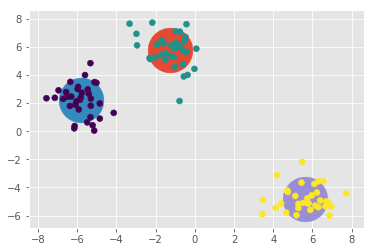

In [7]:
%%time
test(MyKmeans(k=3, random_state=7))

CPU times: user 16.3 ms, sys: 7.53 ms, total: 23.8 ms
Wall time: 22.6 ms


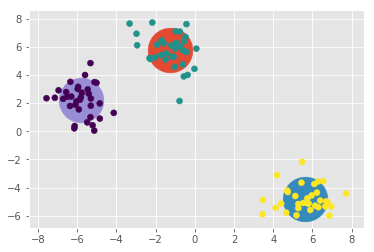

In [8]:
%%time
test(MyKmeans(k=3, init='smart', random_state=7))

CPU times: user 30.3 ms, sys: 3.32 ms, total: 33.7 ms
Wall time: 32.5 ms


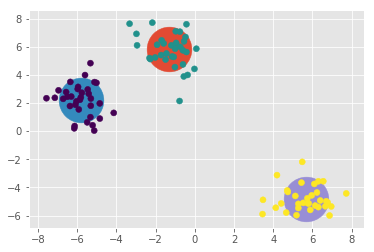

In [9]:
%%time
test(MiniBatchKMeans(k=3, random_state=7))

CPU times: user 32.7 ms, sys: 91 µs, total: 32.8 ms
Wall time: 31.2 ms


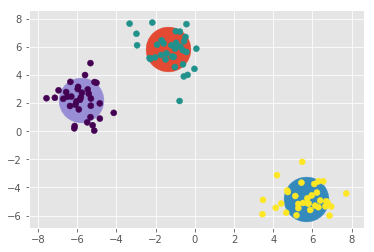

In [10]:
%%time
test(MiniBatchKMeans(k=3, init='smart', random_state=7))

CPU times: user 29.5 ms, sys: 138 µs, total: 29.6 ms
Wall time: 29.2 ms


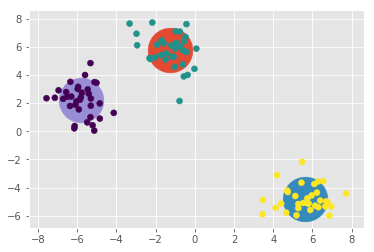

In [11]:
%%time
test(KMeans(n_clusters=3, random_state=7, tol=1e-1))

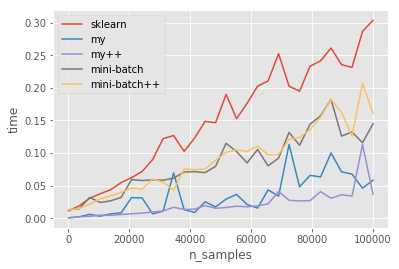

In [12]:
sz = np.linspace(100, 100000, 30, dtype=np.int)
models = [
    (KMeans(n_clusters=3, random_state=7, tol=1e-2), 'sklearn'),
    (MyKmeans(k=3, random_state=7), 'my'),
    (MyKmeans(k=3, init='smart', random_state=7), 'my++'),
    (MiniBatchKMeans(k=3, random_state=7), 'mini-batch'),
    (MiniBatchKMeans(k=3, init='smart', random_state=7), 'mini-batch++')
]

for model, name in models:
    t = []
    for k in sz:
        X, _ = make_blobs(n_samples=k, n_features=2, centers=3, 
                          cluster_std=1, shuffle=True, random_state=7)
        start = timer()
        model.fit(X)
        finish = timer() - start
        t.append(finish)
    plt.plot(sz, t, label=name)

plt.xlabel('n_samples')
plt.ylabel('time')
plt.legend()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [13]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [14]:
df = df_sns.drop(labels=df_sns.columns[:4], axis=1)
X = df.values
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [15]:
def print_clusters(model, n=10):
    model.fit(X)
    for i in range(9):
        idxs = X[model.labels == i].sum(axis=0).argsort()[-n:][::-1]
        sz = X[model.labels == i].shape[0]
        print(
            'cluster {}\n    size: {}\n    top-n: {}'.format(
                i + 1,
                sz,
                ', '.join(df.columns[idxs].values)
            )
        )

In [16]:
## MyKMeans
print_clusters(MyKmeans(k=9))

cluster 1
    size: 377
    top-n: bible, jesus, god, church, death, die, music, rock, basketball, band
cluster 2
    size: 915
    top-n: kissed, drugs, hair, sex, drunk, die, rock, clothes, music, death
cluster 3
    size: 2071
    top-n: swimming, shopping, soccer, volleyball, tennis, music, baseball, sports, blonde, death
cluster 4
    size: 742
    top-n: marching, band, music, rock, football, god, death, tennis, dance, dress
cluster 5
    size: 19442
    top-n: blonde, tennis, baseball, jesus, bible, soccer, death, drunk, volleyball, die
cluster 6
    size: 594
    top-n: softball, volleyball, basketball, sports, baseball, football, shopping, clothes, church, hair
cluster 7
    size: 645
    top-n: cheerleading, shopping, football, cute, hot, mall, basketball, dance, baseball, rock
cluster 8
    size: 4385
    top-n: cute, shopping, mall, dance, dress, hot, clothes, sexy, church, football
cluster 9
    size: 829
    top-n: hollister, abercrombie, shopping, mall, clothes, hair, ho

In [17]:
## MyKMeans++
print_clusters(MyKmeans(k=9, init='smart'))

cluster 1
    size: 2606
    top-n: football, basketball, baseball, sports, soccer, volleyball, tennis, rock, cheerleading, swimming
cluster 2
    size: 856
    top-n: hollister, abercrombie, shopping, mall, clothes, hair, cheerleading, hot, cute, swimming
cluster 3
    size: 935
    top-n: kissed, drugs, hair, sex, drunk, die, rock, clothes, music, death
cluster 4
    size: 502
    top-n: bible, jesus, god, church, death, music, die, rock, band, swimming
cluster 5
    size: 4289
    top-n: shopping, cute, mall, dance, dress, hot, clothes, sexy, cheerleading, hair
cluster 6
    size: 580
    top-n: marching, band, music, rock, football, god, swimming, dance, tennis, church
cluster 7
    size: 501
    top-n: softball, basketball, volleyball, sports, shopping, football, clothes, church, baseball, dress
cluster 8
    size: 1
    top-n: sex, church, death, rock, music, blonde, bible, marching, tennis, drugs
cluster 9
    size: 19730
    top-n: blonde, tennis, jesus, death, bible, drunk, di

In [18]:
## MyKMeans с MiniBatchMyKMeans
print_clusters(MiniBatchKMeans(k=9))

cluster 1
    size: 35
    top-n: tennis, band, hollister, church, swimming, volleyball, abercrombie, music, football, sports
cluster 2
    size: 367
    top-n: abercrombie, hollister, shopping, hair, clothes, mall, cheerleading, cute, hot, kissed
cluster 3
    size: 59
    top-n: hollister, swimming, clothes, abercrombie, shopping, hair, mall, hot, kissed, sports
cluster 4
    size: 20
    top-n: sex, hair, blonde, kissed, death, die, cute, drunk, music, rock
cluster 5
    size: 1685
    top-n: hair, dress, kissed, drugs, sex, clothes, rock, music, cute, die
cluster 6
    size: 228
    top-n: bible, jesus, god, church, death, die, music, rock, basketball, drugs
cluster 7
    size: 53
    top-n: drunk, drugs, sex, sexy, kissed, hair, die, death, cute, dance
cluster 8
    size: 26637
    top-n: soccer, volleyball, blonde, baseball, softball, cheerleading, hot, swimming, tennis, sexy
cluster 9
    size: 916
    top-n: marching, band, music, rock, die, softball, church, god, death, footba

In [19]:
## MyKMeans++ с MiniBatchMyKMeans
print_clusters(MiniBatchKMeans(k=9, init='smart'))

cluster 1
    size: 24451
    top-n: bible, blonde, tennis, jesus, swimming, sexy, god, baseball, church, death
cluster 2
    size: 370
    top-n: volleyball, basketball, shopping, softball, sports, football, cute, swimming, hot, church
cluster 3
    size: 299
    top-n: soccer, sports, shopping, basketball, tennis, hair, hot, church, swimming, mall
cluster 4
    size: 11
    top-n: softball, bible, volleyball, basketball, jesus, god, sports, death, clothes, kissed
cluster 5
    size: 294
    top-n: kissed, hair, sex, drugs, music, clothes, drunk, rock, die, sports
cluster 6
    size: 4
    top-n: sex, kissed, church, bible, death, god, cute, jesus, basketball, softball
cluster 7
    size: 766
    top-n: cheerleading, softball, abercrombie, hollister, shopping, basketball, clothes, mall, sports, football
cluster 8
    size: 2467
    top-n: band, marching, dance, hair, music, die, drunk, drugs, cute, clothes
cluster 9
    size: 1338
    top-n: football, basketball, baseball, sports, chu

Лидера выделить не могу. Случайная инициализация может разбивать один кластер на несколько. MiniBatch версия работает быстрее на больших данных. KMeans++ выделяет больее мелкие кластеры, которые иногда лучше интерпритируются.